# Evaluating Scalable Bayesian Deep Learning Methods for Robust Computer Vision

The goal of this notebook is to implement and test different methods in order to make DNN more robust. First, we will import a few useful packages.

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

## Test on a custom toy regression problem

We have an arbitrary amount of synthetic data of very low dimension. The model is the following :
$$y = x\sin (x) + \epsilon (x)$$

Where:
 $$\epsilon \sim \mathcal{N} (0 , \sin(x)^2)$$

We will implement different methods presented in the article and more in order to craft a robust model that captures both the *aleatoric* and the *epistemic* incertainties.

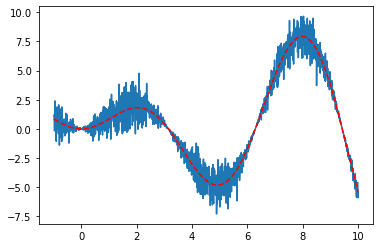

In [ ]:
N = 2000

X = np.linspace(-1, 10, num = N, dtype="float32")
eps = np.random.normal(size = (N))*np.sin(X)
Y = X*np.sin(X) + eps

plt.plot(X, Y)
plt.plot(X, X*np.sin(X) , "r--")
plt.show()

X = np.reshape(X, (N, 1))
Y = np.reshape(Y, (N, 1))

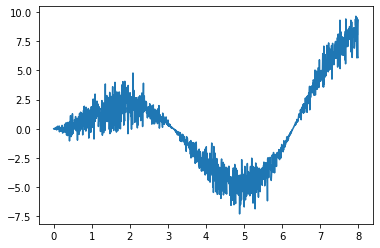

torch.Size([1454, 1])


In [ ]:
X_train = X[(X<8) & (X >0)]
Y_train = Y[(X<8) & (X >0)]

plt.plot(X_train, Y_train)
plt.show()

X_train = torch.tensor(X_train).float().unsqueeze(1)
Y_train = torch.tensor(Y_train).float().unsqueeze(1)

print(X_train.shape)

X = torch.tensor(X).float()
Y = torch.tensor(Y).float()

# create dataset and dataloaders
train_dataset = torch.utils.data.TensorDataset(X_train, Y_train)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256)

test_dataset = torch.utils.data.TensorDataset(X, Y)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=256)

### A deterministic model

In [ ]:
# Simple FF Network, deterministic
class deterministic_FFN(nn.Module):
    def __init__(self, dim1 = 20, dim2 = 20):
        super(deterministic_FFN, self).__init__()
        self.fc1 = nn.Linear(1, dim1)
        self.fc2 = nn.Linear(dim1, dim2)
        self.fc3 = nn.Linear(dim2, 1)
        
    def forward(self, x):
        y = torch.tanh(self.fc1(x))
        y = torch.tanh(self.fc2(y))
        y = self.fc3(y)
        return y

deterministic_model = deterministic_FFN().to(device)
deterministic_model.train()
optimizer = torch.optim.Adam(deterministic_model.parameters())

In [ ]:
num_epochs = 1000
# Start training
loss = torch.nn.MSELoss(reduction = 'mean')
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = deterministic_model(x)

        output = loss(y_pred, y)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %100 == 0:
            print ("Epoch[{}/{}], MSE: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item()))

Epoch[1/1000], MSE: 0.8864
Epoch[101/1000], MSE: 1.0991
Epoch[201/1000], MSE: 1.0796
Epoch[301/1000], MSE: 0.7989
Epoch[401/1000], MSE: 0.7357
Epoch[501/1000], MSE: 0.6932
Epoch[601/1000], MSE: 0.5624
Epoch[701/1000], MSE: 0.4610
Epoch[801/1000], MSE: 0.4182
Epoch[901/1000], MSE: 0.4031


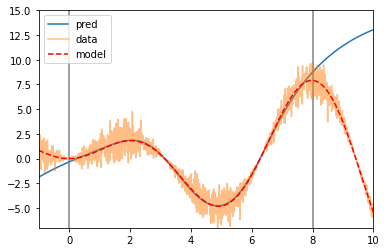

In [ ]:
with torch.no_grad():
  y_pred = deterministic_model(X.to(device)).detach().numpy()
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

plt.plot(X_np , y_pred, label="pred")
plt.plot(X_np, Y_np, label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.legend()
plt.show()

### A Gaussian NN to capture aleatoric uncertainties

In [ ]:
# Simple Gaussian network that infere both a mean and a log variance
class gaussian_FFN(nn.Module):
    def __init__(self, dim1 = 20, dim2 = 20):
        super(gaussian_FFN, self).__init__()
        self.fc1_mean = nn.Linear(1, dim1)
        self.fc2_mean = nn.Linear(dim1, dim2)
        self.fc3_mean = nn.Linear(dim2, 1)


        self.fc1_var = nn.Linear(1, dim1)
        self.fc2_var = nn.Linear(dim1, dim2)
        self.fc3_var = nn.Linear(dim2, 1)

        
    def forward(self, x):
        mean = torch.tanh(self.fc1_mean(x))
        mean = torch.tanh(self.fc2_mean(mean))
        mean = self.fc3_mean(mean)

        var = torch.tanh(self.fc1_var(x))
        var = torch.tanh(self.fc2_var(var))
        var = self.fc3_var(var)
        return mean, var

gaussian_model = gaussian_FFN().to(device)
optimizer = torch.optim.Adam(gaussian_model.parameters())

In [ ]:
num_epochs = 1500
# Start training
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = gaussian_model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %100 == 0:
            print ("Epoch[{}/{}], Loss: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item()))

Epoch[1/1500], Loss: 1.1544
Epoch[101/1500], Loss: 0.0278
Epoch[201/1500], Loss: -0.0809
Epoch[301/1500], Loss: -0.1197
Epoch[401/1500], Loss: -0.2764
Epoch[501/1500], Loss: -0.4191
Epoch[601/1500], Loss: -0.4526
Epoch[701/1500], Loss: -0.4442
Epoch[801/1500], Loss: -0.4254
Epoch[901/1500], Loss: -0.4369
Epoch[1001/1500], Loss: -0.4499
Epoch[1101/1500], Loss: -0.4785
Epoch[1201/1500], Loss: -0.4868
Epoch[1301/1500], Loss: -0.4925
Epoch[1401/1500], Loss: -0.4958


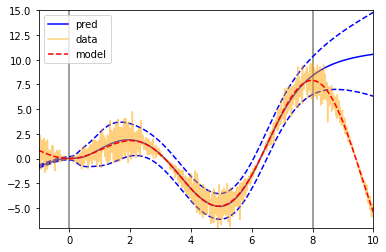

In [ ]:
with torch.no_grad():
  y_pred = gaussian_model(X.to(device))
  mean = y_pred[0].detach().numpy()
  log_var = y_pred[1].detach().numpy()
X_np = X.detach().numpy()
Y_np = Y.detach().numpy()

plt.plot(X_np , mean,"b-" , label="pred")
plt.plot(X_np , mean + 1.96*np.sqrt(np.exp(log_var)),"b--")
plt.plot(X_np , mean - 1.96*np.sqrt(np.exp(log_var)),"b--")
plt.plot(X_np, Y_np, "orange", label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.legend()
plt.show()

### Ensembling through SGLD

In [ ]:
SGLD_gaussian_model = gaussian_FFN().to(device)
optimizer = torch.optim.Adam(SGLD_gaussian_model.parameters())

# Hyperparameters
num_epochs = 1500
M = 64
lr = 0.0001

# Start training
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = SGLD_gaussian_model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %100 == 0:
            print ("Epoch[{}/{}], Loss: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item()))

means = []
vars = []
for m in range(M):
  for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = SGLD_gaussian_model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        with torch.no_grad():
          for param in SGLD_gaussian_model.parameters():
            if param.requires_grad :
              param += np.sqrt(2*torch.mean(torch.abs(param)).item()*lr)*torch.randn_like(param)
          
          y_pred = SGLD_gaussian_model(X.to(device))
          means.append(y_pred[0].detach().numpy())
          vars.append(np.exp(y_pred[1].detach().numpy()))


Epoch[1/1500], Loss: 0.7640
Epoch[101/1500], Loss: 0.2716
Epoch[201/1500], Loss: -0.0278
Epoch[301/1500], Loss: -0.0671
Epoch[401/1500], Loss: -0.1157
Epoch[501/1500], Loss: -0.1656
Epoch[601/1500], Loss: -0.2584
Epoch[701/1500], Loss: -0.3174
Epoch[801/1500], Loss: -0.3494
Epoch[901/1500], Loss: -0.3800
Epoch[1001/1500], Loss: -0.4252
Epoch[1101/1500], Loss: -0.4522
Epoch[1201/1500], Loss: -0.4725
Epoch[1301/1500], Loss: -0.4902
Epoch[1401/1500], Loss: -0.5066


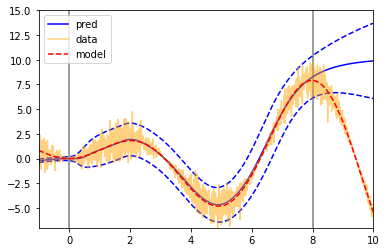

In [ ]:
K = 10
mean = 0
for i in range(K):
  mean += means[i]
mean /= K
var = 0
for i in range(K):
  var += vars[i]
  var += np.power(means[i]-mean , 2)
var /= K

plt.plot(X_np , mean,"b-" , label="pred")
plt.plot(X_np , mean + 1.96*np.sqrt(var),"b--")
plt.plot(X_np , mean - 1.96*np.sqrt(var),"b--")
plt.plot(X_np, Y_np, "orange", label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.legend()
plt.show()

### MC-Dropout

In [ ]:
# Simple Gaussian network that infere both a mean and a log variance
class dropout_FFN(nn.Module):
    def __init__(self, dim1 = 20, dim2 = 20, p_d = 0.1):
        super(dropout_FFN, self).__init__()
        self.fc1_mean = nn.Linear(1, dim1)
        self.fc2_mean = nn.Linear(dim1, dim2)
        self.fc3_mean = nn.Linear(dim2, 1)


        self.fc1_var = nn.Linear(1, dim1)
        self.fc2_var = nn.Linear(dim1, dim2)
        self.fc3_var = nn.Linear(dim2, 1)

        self.p_d = p_d

        
    def forward(self, x):
        mean = torch.tanh(self.fc1_mean(x))
        mean = F.dropout(mean, p=self.p_d, training = True)
        mean = torch.tanh(self.fc2_mean(mean))
        mean = self.fc3_mean(mean)

        var = torch.tanh(self.fc1_var(x))
        var = F.dropout(var, p=self.p_d, training = True)        
        var = torch.tanh(self.fc2_var(var))
        var = self.fc3_var(var)
        return mean, var

dropout_model = dropout_FFN().to(device)
optimizer = torch.optim.Adam(dropout_model.parameters())

In [ ]:
num_epochs = 1500
# Start training
dropout_model.train()
for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = dropout_model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %100 == 0:
            print ("Epoch[{}/{}], Loss: {:.4f}" 
                   .format(epoch+1, num_epochs, output.item()))

Epoch[1/1500], Loss: 0.7157
Epoch[101/1500], Loss: 0.0335
Epoch[201/1500], Loss: -0.0913
Epoch[301/1500], Loss: -0.0426
Epoch[401/1500], Loss: -0.0823
Epoch[501/1500], Loss: -0.1131
Epoch[601/1500], Loss: -0.3225
Epoch[701/1500], Loss: -0.3689
Epoch[801/1500], Loss: -0.4119
Epoch[901/1500], Loss: -0.4435
Epoch[1001/1500], Loss: -0.4604
Epoch[1101/1500], Loss: -0.4641
Epoch[1201/1500], Loss: -0.4310
Epoch[1301/1500], Loss: -0.4583
Epoch[1401/1500], Loss: -0.4561


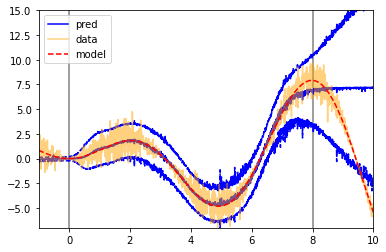

In [ ]:
K = 10
means = []
vars = []
for i in range(K):
  y_pred = dropout_model(X.to(device))
  means.append(y_pred[0].detach().numpy())
  vars.append(np.exp(y_pred[1].detach().numpy()))

mean = 0
for i in range(K):
  mean += means[i]
mean /= K
var = 0
for i in range(K):
  var += vars[i]
  var += np.power(means[i]-mean , 2)
var /= K

plt.plot(X_np , mean,"b-" , label="pred")
plt.plot(X_np , mean + 1.96*np.sqrt(var),"b--")
plt.plot(X_np , mean - 1.96*np.sqrt(var),"b--")
plt.plot(X_np, Y_np, "orange", label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.legend()
plt.show()

### Bagging along sub-intervals

In [ ]:
means = []
vars = []
M = 10
num_epochs = 1500

intervals = []

for model_num in range(M):
  print(f"Training model n°{model_num + 1}")
  interval_size = (3+np.random.random())*2
  interval_begin = np.random.random()*(8-interval_size)

  # create dataset and dataloaders
  bagged_dataset = torch.utils.data.TensorDataset(torch.tensor(X_np[(X<interval_begin+interval_size) & (X >interval_begin)]).unsqueeze(1),
                                                  torch.tensor(Y_np[(X<interval_begin+interval_size) & (X >interval_begin)]).unsqueeze(1))
  bagged_loader = torch.utils.data.DataLoader(bagged_dataset, batch_size=512)

  intervals.append(interval_begin)
  intervals.append(interval_begin+interval_size)

  model = gaussian_FFN().to(device)
  optimizer = torch.optim.Adam(model.parameters())

  for epoch in range(num_epochs):
    for i, (x, y) in enumerate(bagged_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %500 == 0:
            print ("Epoch[{}/{}], Loss: {:.4f}" 
                   .format(epoch, num_epochs, output.item()))
            
  y_pred = model(X.to(device))
  means.append(y_pred[0].detach().numpy())
  vars.append(np.exp(y_pred[1].detach().numpy()))

Training model n°1
Epoch[0/1500], Loss: 2.2818
Epoch[500/1500], Loss: 0.6479
Epoch[1000/1500], Loss: 0.4858
Training model n°2
Epoch[0/1500], Loss: 2.5624
Epoch[500/1500], Loss: 1.3702
Epoch[1000/1500], Loss: 0.9345
Training model n°3
Epoch[0/1500], Loss: 3.2727
Epoch[500/1500], Loss: 0.9517
Epoch[1000/1500], Loss: 0.4175
Training model n°4
Epoch[0/1500], Loss: 2.0867
Epoch[500/1500], Loss: 0.8321
Epoch[1000/1500], Loss: 0.5059
Training model n°5
Epoch[0/1500], Loss: 2.1025
Epoch[500/1500], Loss: 0.8024
Epoch[1000/1500], Loss: 0.5228
Training model n°6
Epoch[0/1500], Loss: 2.0403
Epoch[500/1500], Loss: 1.1419
Epoch[1000/1500], Loss: 0.5862
Training model n°7
Epoch[0/1500], Loss: 2.7996
Epoch[500/1500], Loss: 1.2385
Epoch[1000/1500], Loss: 0.5050
Training model n°8
Epoch[0/1500], Loss: 1.5791
Epoch[500/1500], Loss: 0.8138
Epoch[1000/1500], Loss: 0.5228
Training model n°9
Epoch[0/1500], Loss: 2.7327
Epoch[500/1500], Loss: 1.1917
Epoch[1000/1500], Loss: 0.3369
Training model n°10
Epoch[0/

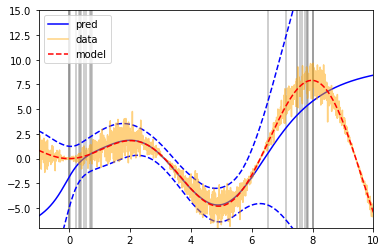

In [ ]:
K = 10
mean = 0
for i in range(K):
  mean += means[i]
mean /= K
var = 0
for i in range(K):
  var += vars[i]
  var += np.power(means[i]-mean , 2)
var /= K

plt.plot(X_np , mean,"b-" , label="pred")
plt.plot(X_np , mean + 1.96*np.sqrt(var),"b--")
plt.plot(X_np , mean - 1.96*np.sqrt(var),"b--")
plt.plot(X_np, Y_np, "orange", label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
for x_i in intervals[0:K*2] :
  plt.vlines(x_i , -7, 15, colors = "gray", alpha = 0.5)
plt.legend()
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.show()

### Ensembling

In [ ]:
means = []
vars = []
M = 10
num_epochs = 1500

intervals = []

for model_num in range(M):
  print(f"Training model n°{model_num + 1}")
  model = gaussian_FFN().to(device)
  optimizer = torch.optim.Adam(model.parameters())
  
  for epoch in range(num_epochs):
    for i, (x, y) in enumerate(train_loader):
        # Forward pass
        x = x.to(device)
        y = y.to(device)

        y_pred = model(x)

        mean = y_pred[0]
        log_var = y_pred[1]

        output = torch.mean(torch.exp(-log_var)*torch.pow(y - mean, 2) + log_var)

        optimizer.zero_grad()
        output.backward()
        optimizer.step()
        
        if i == 0 and epoch %500 == 0:
            print ("Epoch[{}/{}], Loss: {:.4f}" 
                   .format(epoch, num_epochs, output.item()))
            
  y_pred = model(X.to(device))
  means.append(y_pred[0].detach().numpy())
  vars.append(np.exp(y_pred[1].detach().numpy()))

Training model n°1
Epoch[0/1500], Loss: 0.9462
Epoch[500/1500], Loss: -0.1948
Epoch[1000/1500], Loss: -0.4097
Training model n°2
Epoch[0/1500], Loss: 1.0182
Epoch[500/1500], Loss: -0.2029
Epoch[1000/1500], Loss: -0.3885
Training model n°3
Epoch[0/1500], Loss: 1.1811
Epoch[500/1500], Loss: -0.2428
Epoch[1000/1500], Loss: -0.4582
Training model n°4
Epoch[0/1500], Loss: 0.6639
Epoch[500/1500], Loss: -0.2110
Epoch[1000/1500], Loss: -0.5011
Training model n°5
Epoch[0/1500], Loss: 0.9170
Epoch[500/1500], Loss: -0.2392
Epoch[1000/1500], Loss: -0.4233
Training model n°6
Epoch[0/1500], Loss: 1.1583
Epoch[500/1500], Loss: -0.3302
Epoch[1000/1500], Loss: -0.4899
Training model n°7
Epoch[0/1500], Loss: 1.7464
Epoch[500/1500], Loss: -0.2844
Epoch[1000/1500], Loss: -0.4124
Training model n°8
Epoch[0/1500], Loss: 0.8723
Epoch[500/1500], Loss: -0.3552
Epoch[1000/1500], Loss: -0.4949
Training model n°9
Epoch[0/1500], Loss: 0.7059
Epoch[500/1500], Loss: -0.2884
Epoch[1000/1500], Loss: -0.4904
Training m

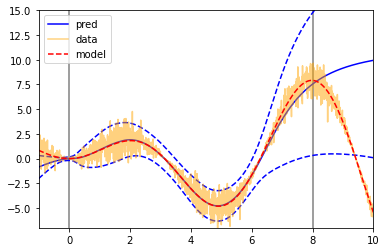

In [ ]:
K = 10
mean = 0
for i in range(K):
  mean += means[i]
mean /= K
var = 0
for i in range(K):
  var += vars[i]
  var += np.power(means[i]-mean , 2)
var /= K

plt.plot(X_np , mean,"b-" , label="pred")
plt.plot(X_np , mean + 1.96*np.sqrt(var),"b--")
plt.plot(X_np , mean - 1.96*np.sqrt(var),"b--")
plt.plot(X_np, Y_np, "orange", label = "data", alpha = 0.5)
plt.plot(X_np, X_np*np.sin(X_np) , "r--", label = "model")
plt.vlines(0 , -7, 15, colors = "gray")
plt.vlines(8 , -7, 15, colors = "gray")
plt.ylim(-7, 15)
plt.xlim(-1, 10)
plt.legend()
plt.show()